In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load the dataset
df = pd.read_csv('../data/ML471_S1_Datafile_Concept.csv')

# Preprocessing
# Convert DATE to datetime and set as index
# The format is MM-DD-YYYY where DD is always 01
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df = df.asfreq('MS') # Monthly Start frequency

# Splitting into training (80%) and testing (20%) sets
train_size = int(len(df) * 0.8)
train, test = df['Consumption'][:train_size], df['Consumption'][train_size:]

print(f"Total observations: {len(df)}")
print(f"Training observations: {len(train)}")
print(f"Testing observations: {len(test)}")

Total observations: 397
Training observations: 317
Testing observations: 80


In [6]:
# Fit ARIMA(2,1,2) model
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                  317
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -819.526
Date:                Sun, 01 Feb 2026   AIC                           1649.053
Time:                        09:35:47   BIC                           1667.831
Sample:                    01-01-1988   HQIC                          1656.555
                         - 05-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9982      0.002    532.954      0.000       0.995       1.002
ar.L2         -0.9994      0.001   -831.170      0.000      -1.002      -0.997
ma.L1         -1.0624      0.055    -19.207      0.0

In [7]:
# Residual Autocorrelation Check
residuals = model_fit.resid
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test Results:")
print(lb_test)

if lb_test['lb_pvalue'].iloc[0] > 0.05:
    print("\nResiduals resemble white noise (p > 0.05).")
else:
    print("\nResiduals show significant autocorrelation (p <= 0.05).")

Ljung-Box Test Results:
     lb_stat  lb_pvalue
10  5.754083   0.835484

Residuals resemble white noise (p > 0.05).


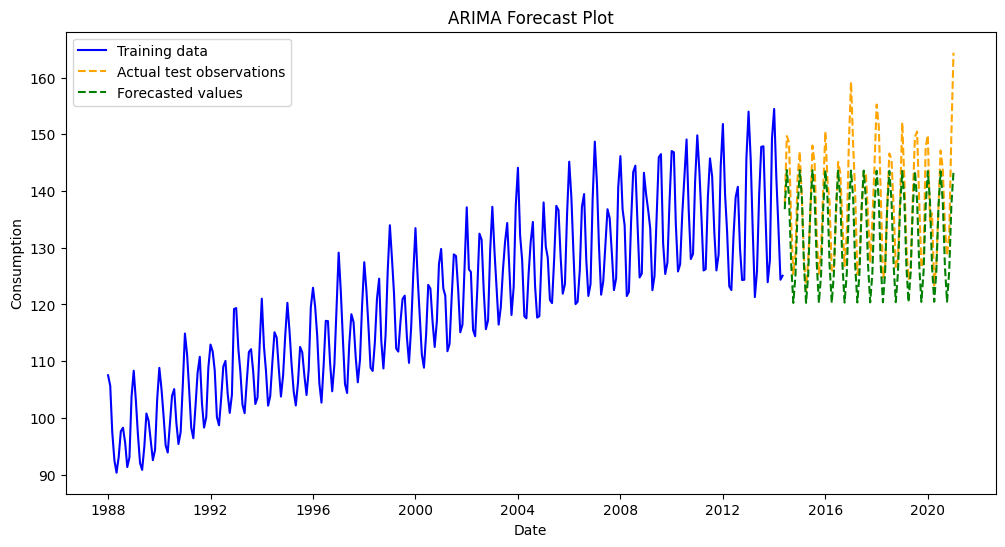

In [8]:
# Forecast for the test period
forecast = model_fit.forecast(steps=len(test))

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training data', color='blue')
plt.plot(test.index, test, label='Actual test observations', color='orange', linestyle='--')
plt.plot(test.index, forecast, label='Forecasted values', color='green', linestyle='--')
plt.title('ARIMA Forecast Plot')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()
plt.show()

In [9]:
# Forecast Accuracy Metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

def calculate_mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

mape = calculate_mape(test, forecast)

print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}%')
print(f'RMSE: {rmse:.4f}')

MAE: 5.6882
MAPE: 4.0465%
RMSE: 7.0209


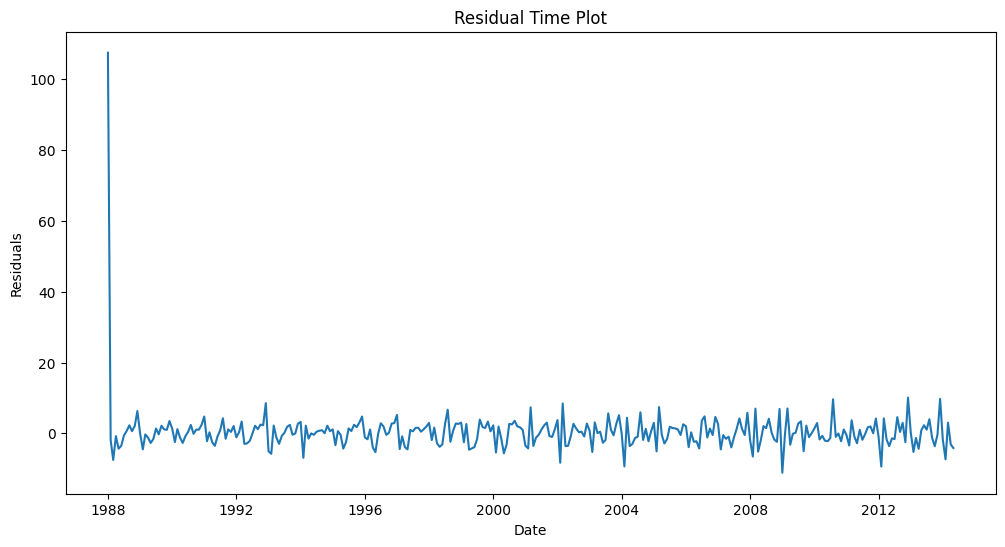

In [10]:
# Residual Diagnostics - Residual Time Plot
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residual Time Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()